In [127]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PolynomialFeatures, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import catboost as cb
from xgboost import XGBRegressor, XGBClassifier
import itertools
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [128]:
def my_data_transformer(X, scaler_minmax_to_use=np.nan, scaler_normalize_to_use=np.nan, scaler_minmax_for_cross_to_use=np.nan, scaler_standard_for_pca_to_use=np.nan, pca_to_use=np.nan):
    X_copy = X.copy()
    
    # 1. Временно убираем категориальный признак 
    X_cover_angle = pd.DataFrame(X_copy.pop('cover_angle'))
    
    # 2. Приводим к единому масштабу данных - [0, 1] - через MinMaxScaler
    scaler_minmax = scaler_minmax_to_use if scaler_minmax_to_use is not np.nan else MinMaxScaler().fit(X_copy)
    X_scaled = pd.DataFrame(scaler_minmax.transform(X_copy), index=X_copy.index, columns=X_copy.columns.tolist())
    
    # 3. Создание новых признаков: Нормализуем по строкам (по наблюдениям = горизонтально), а не по признакам (вертикально), т.к. по признакам корреляция с целевой переменной незначительная
    scaler_normalize = scaler_normalize_to_use if scaler_normalize_to_use is not np.nan else Normalizer().fit(X_copy)
    X_norm = pd.DataFrame(scaler_normalize.transform(X_copy), index=X_copy.index, columns=[f'{col}_norm' for col in X_copy.columns.tolist()])    
    
    # 4. Создание новых признаков: попарное перемножение 
    col_names = X_copy.columns.tolist()
    col_pair_combinations = list(itertools.combinations(col_names, 2))
    X_cross = []
    for col_pair in col_pair_combinations:
        X_cross.append(X_copy.loc[:, col_pair].apply(lambda x: x[0] * x[1], axis=1))
    X_cross = pd.DataFrame(X_cross).T
    X_cross.columns = [f'{col_name[0]}_cross_{col_name[1]}' for col_name in col_pair_combinations]
    # Нормализуем получившиеся значения - приводим к масштабу данных в диапазоне [0-1]
    scaler_minmax_for_cross = scaler_minmax_for_cross_to_use if scaler_minmax_for_cross_to_use is not np.nan else MinMaxScaler().fit(X_cross)
    X_cross_scaled = pd.DataFrame(scaler_minmax_for_cross.transform(X_cross), index=X_copy.index, columns=X_cross.columns.tolist())          
        
    # 5. Создание новых признаков: главные компоненты (PCA)
    scaler_standard_for_pca = scaler_standard_for_pca_to_use if scaler_standard_for_pca_to_use is not np.nan else StandardScaler().fit(X_copy)
    X_stand = scaler_standard_for_pca.transform(X_copy)
    pca = pca_to_use if pca_to_use is not np.nan else PCA(random_state=42).fit(X_stand)
    X_pca = pd.DataFrame(pca.transform(X_stand), index=X_copy.index, columns=[f'PC_{i + 1}' for i in np.arange(X_stand.shape[1])])
    # plt.figure(figsize=(20, 6))
    # sns.barplot(x=X_pca.columns, y=pca.explained_variance_ratio_);
    
    # Собираем все признаки в один датасет, включая ранее временно исключенный категориальный
    X_to_use = pd.concat([X_scaled, X_norm, X_cross_scaled, X_pca, X_cover_angle], axis=1).reset_index(drop=True)
    
    return X_to_use      
        

# Выбор наилучшего метода для задачи на целевую переменную 'Модуль упругости при растяжении' (elasticity_on_stretching)

### Загружаем подготовленные данные

In [129]:
data_elasticity = pd.read_csv('../../data/data_for_model/elasticity_on_stretching_data_to_use.csv', sep=';', index_col=[0])
data_elasticity

,elasticity_on_stretching,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox
0,73.333333,4.029126,1880.000000,111.860000,22.267857,284.615385,220.000000,1,4.000000,279.881315,76.957677,121.275785
1,80.803222,2.587348,1953.274926,137.627420,22.344534,234.716883,246.613117,1,4.000000,468.070285,85.775121,146.039613
2,76.178075,2.499918,1942.595777,146.252208,23.081757,351.231874,226.222760,1,5.000000,384.144381,114.030162,90.397231
3,73.817067,2.046471,2037.631811,101.617251,23.146393,312.307205,178.198556,1,5.000000,312.424362,84.946656,114.010469
4,77.210762,1.856476,2018.220332,135.401697,26.435515,327.510377,123.344561,1,5.000000,360.307864,36.705334,121.275785
...,...,...,...,...,...,...,...,...,...,...,...,...
931,73.090961,2.271346,1952.087902,86.992183,20.123249,324.774576,125.007669,1,9.076380,388.260338,45.465881,90.442938
932,72.920827,3.444022,2050.089171,145.981978,19.599769,254.215401,117.730099,1,10.565614,210.177541,63.654329,106.233019
933,74.734344,3.280604,1972.372865,110.533477,23.957502,248.423047,236.606764,1,4.161154,198.863724,103.165218,140.097049
934,74.042708,3.705351,2066.799773,141.397963,19.246945,275.779840,197.126067,1,6.313201,325.153429,94.077815,117.054830


In [130]:
data_elasticity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   elasticity_on_stretching  936 non-null    float64
 1   matrix_filler_ratio       936 non-null    float64
 2   density                   936 non-null    float64
 3   hardener                  936 non-null    float64
 4   epoxid                    936 non-null    float64
 5   temperature               936 non-null    float64
 6   resin                     936 non-null    float64
 7   cover_angle               936 non-null    int64  
 8   cover_step                936 non-null    float64
 9   elasticity_boxcox         936 non-null    float64
 10  surface_density_boxcox    936 non-null    float64
 11  cover_strength_boxcox     936 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 95.1 KB


In [131]:
data_elasticity.describe()

,elasticity_on_stretching,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox
count,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000
mean,73.306409,2.933634,1973.997850,110.439101,22.237936,285.518860,217.535393,0.516026,6.903379,319.257914,74.735890,115.174499
std,3.033551,0.893405,70.683803,27.270888,2.421027,39.819233,57.866217,0.500010,2.526364,125.080870,31.164550,27.411562
min,65.553336,0.547391,1784.482245,35.599697,15.695894,179.374391,63.685698,0.000000,0.037639,2.185415,0.550851,43.833385
25%,71.306242,2.334609,1924.037615,91.918258,20.553984,258.539199,179.041257,0.000000,5.127601,231.508299,53.438618,97.488877
50%,73.230375,2.908811,1977.258043,110.162666,22.214281,285.386175,216.691628,1.000000,6.922196,323.955583,75.815031,115.148198
75%,75.314494,3.552539,2020.158764,130.311975,24.005003,313.053889,256.854913,1.000000,8.585130,406.163109,99.169807,132.573811
max,81.417126,5.314144,2161.565216,181.828448,28.955094,386.067992,359.052220,1.000000,13.732404,642.948709,155.347638,187.261670


### Переводим задачу регрессии в задачу классификации - присваиваем целевой переменной лейблы (классы)

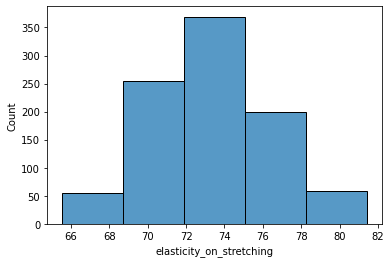

In [132]:
n_bins = 5
sns.histplot(data_elasticity['elasticity_on_stretching'], bins=n_bins);

In [133]:
counts, binEdges = np.histogram(data_elasticity['elasticity_on_stretching'], bins=n_bins)

In [134]:
counts

array([ 55, 254, 369, 200,  58], dtype=int64)

In [135]:
binEdges

array([65.55333591, 68.72609392, 71.89885192, 75.07160993, 78.24436794,
       81.41712594])

In [136]:
data_elasticity['Label'] = np.digitize(data_elasticity['elasticity_on_stretching'], binEdges, right=False).ravel()

In [137]:
data_elasticity.loc[data_elasticity['elasticity_on_stretching'].argmax(), 'Label'] = n_bins

In [138]:
# Делаем отсчёт лейблов с 0 (т.к. это требование большинства алгоритмов) 
data_elasticity['Label'] = data_elasticity['Label'] - 1

In [139]:
classes_values = data_elasticity.groupby('Label')[['elasticity_on_stretching']].mean()
classes_values.to_csv('../../app/model_to_use/elasticity_on_stretching_aver_values.csv', index=True)
classes_values

,elasticity_on_stretching
Label,
0,67.512709
1,70.542082
2,73.453378
3,76.349308
4,79.478497


In [140]:
elasticity_on_stratching_avel_values = pd.read_csv('../../app/model_to_use/elasticity_on_stretching_aver_values.csv', index_col=[0])['elasticity_on_stretching'].to_dict()
elasticity_on_stratching_avel_values[0]

67.51270913284067

In [141]:
# Удаляем столбец с исходными значениями целевой переменной, оставляя только labels классов
data_elasticity = data_elasticity.drop(columns=['elasticity_on_stretching'])
data_elasticity

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox,Label
0,4.029126,1880.000000,111.860000,22.267857,284.615385,220.000000,1,4.000000,279.881315,76.957677,121.275785,2
1,2.587348,1953.274926,137.627420,22.344534,234.716883,246.613117,1,4.000000,468.070285,85.775121,146.039613,4
2,2.499918,1942.595777,146.252208,23.081757,351.231874,226.222760,1,5.000000,384.144381,114.030162,90.397231,3
3,2.046471,2037.631811,101.617251,23.146393,312.307205,178.198556,1,5.000000,312.424362,84.946656,114.010469,2
4,1.856476,2018.220332,135.401697,26.435515,327.510377,123.344561,1,5.000000,360.307864,36.705334,121.275785,3
...,...,...,...,...,...,...,...,...,...,...,...,...
931,2.271346,1952.087902,86.992183,20.123249,324.774576,125.007669,1,9.076380,388.260338,45.465881,90.442938,2
932,3.444022,2050.089171,145.981978,19.599769,254.215401,117.730099,1,10.565614,210.177541,63.654329,106.233019,2
933,3.280604,1972.372865,110.533477,23.957502,248.423047,236.606764,1,4.161154,198.863724,103.165218,140.097049,2
934,3.705351,2066.799773,141.397963,19.246945,275.779840,197.126067,1,6.313201,325.153429,94.077815,117.054830,2


In [142]:
count_samples_by_labels = data_elasticity['Label'].value_counts().sort_index()
count_samples_by_labels

0     55
1    254
2    369
3    200
4     58
Name: Label, dtype: int64

### Исправляем дисбаланс классов

In [143]:
label_max_count = count_samples_by_labels.max()
labels_coeff_for_oversampl = []

for i in np.arange(n_bins):
    labels_coeff_for_oversampl.append(label_max_count//count_samples_by_labels[i])
    
labels_coeff_for_oversampl

[6, 1, 1, 1, 6]

In [144]:
def fix_undersampling(data, label, max_count):
    label_df = data.loc[data['Label'] == label, :]
    init_count = label_df.shape[0]
    new_df = pd.DataFrame()
    while new_df.shape[0] < max_count:    
        current_count = new_df.shape[0]
        sample_size = np.min([init_count, (max_count - current_count)])
        subset = label_df.sample(sample_size)
        new_df = pd.concat([new_df, subset], axis=0)
    new_df = new_df.reset_index(drop=True)
    return new_df

In [145]:
data_elasticity_to_use = pd.DataFrame()

for i in np.arange(n_bins):
    data_elasticity_to_use = pd.concat([data_elasticity_to_use, fix_undersampling(data_elasticity, i, label_max_count)], axis=0).reset_index(drop=True)
    
data_elasticity_to_use

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox,Label
0,2.758727,2000.506141,143.021859,21.379518,273.852679,229.780372,1,8.736592,396.121735,20.985657,121.952546,0
1,3.459775,1902.152941,109.838112,20.444667,218.611309,138.141777,0,4.214774,440.047955,7.357607,111.047047,0
2,2.571758,2066.355044,170.332558,26.546042,246.027954,190.242138,1,8.237030,211.251602,111.902958,89.419032,0
3,1.750613,2033.664073,81.017478,23.693207,269.253574,172.281972,0,6.105035,146.741574,122.032096,48.370100,0
4,3.310900,1975.617983,123.899945,24.000739,361.265523,135.266582,0,6.720534,154.099583,111.170760,126.193598,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1840,3.228435,2019.043878,88.459308,20.583309,276.711107,272.671714,1,9.315287,261.266847,89.441779,116.328150,4
1841,2.041113,1977.661795,169.091634,22.128388,243.067123,161.751860,1,7.827562,353.407429,107.907398,133.748009,4
1842,3.267523,2107.549113,60.994261,27.312167,268.485007,340.016626,0,4.570892,314.148291,31.819087,167.818781,4
1843,2.531957,1919.056276,58.261874,19.875443,286.139430,216.774102,1,5.317428,192.272475,40.838466,152.253088,4


In [146]:
data_elasticity_to_use['Label'].value_counts()

0    369
1    369
2    369
3    369
4    369
Name: Label, dtype: int64

### На всякий случай принудительно производим случайное перемешивание по строкам

In [147]:
data_elasticity_to_use = data_elasticity_to_use.sample(frac=1, random_state=42).reset_index(drop=True)
data_elasticity_to_use

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox,Label
0,3.354766,2009.714944,162.209300,19.111948,343.068539,278.592086,1,3.756586,390.873175,44.360580,123.960684,4
1,2.041352,1967.037527,131.215489,21.845144,341.412675,239.241272,0,10.330216,215.170299,109.561234,132.491792,3
2,4.230842,2019.887911,113.258675,21.764122,272.121046,181.862151,1,3.881670,222.128367,107.813839,148.317174,2
3,3.900539,2025.608322,170.892293,25.281753,195.534573,247.622708,1,5.301040,377.734313,93.751931,109.364333,4
4,3.560760,1935.832762,104.531155,23.258366,319.567735,171.223084,1,5.935934,580.236518,94.008011,126.963267,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1840,3.560760,1935.832762,104.531155,23.258366,319.567735,171.223084,1,5.935934,580.236518,94.008011,126.963267,3
1841,1.735248,1986.156488,86.964801,20.850255,244.897665,246.176820,1,7.575362,368.908518,59.399759,129.805928,3
1842,3.355421,1995.549153,110.738213,24.696093,193.431144,280.880603,1,7.933368,414.190032,106.053142,90.268620,2
1843,3.311244,2076.665686,57.005741,18.847271,298.230819,275.915787,1,6.027006,451.475904,43.897260,162.249624,3


### Делим датасет на train и test

In [148]:
y = data_elasticity_to_use[['Label']]
X = data_elasticity_to_use.drop(columns=['Label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y.values.ravel(), random_state=42)

In [149]:
X_train.describe()

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox
count,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000
mean,2.936808,1972.206142,109.704879,22.063203,284.855542,218.956022,0.524400,6.938167,317.507562,75.352359,115.237024
std,0.909247,69.823892,28.808221,2.418667,40.664339,57.194798,0.499598,2.564810,124.889582,31.064802,26.745811
min,0.547391,1784.482245,35.599697,15.695894,179.374391,63.685698,0.000000,0.037639,3.714145,1.517736,43.833385
25%,2.338424,1923.255135,90.206705,20.469182,257.285562,179.766002,0.000000,5.082106,226.638474,52.977559,98.020093
50%,2.906157,1975.493358,109.117129,21.992954,281.534696,218.448971,1.000000,6.968698,322.416112,76.605130,115.522869
75%,3.552036,2019.706055,129.530717,23.912848,314.542188,256.784428,1.000000,8.702715,405.213807,99.414032,132.512970
max,5.314144,2161.565216,181.828448,28.955094,386.067992,359.052220,1.000000,13.653987,642.948709,155.347638,187.261670


In [150]:
X_test.describe()

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox
count,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000
mean,2.940158,1973.880131,110.979920,22.290458,286.338524,220.210083,0.546931,6.871214,316.819484,74.389078,117.458085
std,0.904082,72.105967,27.068535,2.530474,39.151576,59.822116,0.498242,2.439024,125.822357,30.319278,27.356842
min,0.551508,1801.940695,38.668500,15.695894,187.977965,72.530873,0.000000,0.730260,2.185415,0.550851,43.833385
25%,2.343798,1923.887189,91.669042,20.588993,258.574041,181.454964,0.000000,5.090387,223.745122,53.020652,98.768318
50%,2.917219,1977.126504,110.511179,22.230744,286.319834,220.271607,1.000000,6.768666,325.442370,76.137061,115.816737
75%,3.533250,2017.511337,130.855616,24.223246,312.993448,259.881691,1.000000,8.503234,403.399888,96.024330,134.210843
max,5.295842,2161.565216,181.032809,28.907470,385.697799,356.925975,1.000000,13.732404,642.948709,142.792778,183.735343


In [151]:
# X_train_to_use = my_data_transformer(X_train)
# X_train_to_use

### Временно убираем категориальный признак из основного датасета и сохраняем в отдельной переменной

In [152]:
cover_angle_train = pd.DataFrame(X_train.pop('cover_angle'))
cover_angle_test = pd.DataFrame(X_test.pop('cover_angle'))

# Осуществляем разные транформации признаков

### Нормализуем X_train
### Сначала нормализуем через MinMaxScaler (приводим значения к единому масштабу)
### Далее... Т.к. корреляция признаков с целевой переменной практически отсутствует (feature-wise), то предполагаем, что более значимым может быть взаимосвязь целевой переменной с разным набором признаков, взятых как единое целое (рецептура), т.е. по горизонтали (sample-wise). Для этого ещё дополнительно нормализуем по горизонтали через Normalizer()

In [153]:
# Приводим к единому масштабу данных от 0 до 1
scaler_minmax = MinMaxScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler_minmax.transform(X_train), index=X_train.index, columns=X_train.columns.tolist())

# Сохраняем Scaler (для дальнейшего использования в релизе модели)
pickle.dump(scaler_minmax, open('../../app/model_to_use/scaler_minmax_for_elasticity_model.pkl', 'wb'))

In [154]:
# Нормализуем по строкам (по наблюдениям = горизонтально), а не по признакам (вертикально), т.к. по признакам корреляция с целевой переменной незначительная
scaler_normalize = Normalizer().fit(X_train)
X_train_norm = pd.DataFrame(scaler_normalize.transform(X_train), index=X_train.index, columns=[f'{col}_norm' for col in X_train.columns.tolist()])

# Сохраняем Scaler (для дальнейшего использования в релизе модели)
pickle.dump(scaler_normalize, open('../../app/model_to_use/scaler_normalize_for_elasticity_model.pkl', 'wb'))

### Попарное перемножение признаков

In [155]:
col_names = X_train.columns.tolist()
col_pair_combinations = list(itertools.combinations(col_names, 2))

X_train_cross = []

for col_pair in col_pair_combinations:
    X_train_cross.append(X_train.loc[:, col_pair].apply(lambda x: x[0] * x[1], axis=1))
    
X_train_cross = pd.DataFrame(X_train_cross).T
X_train_cross.columns = [f'{col_name[0]}_cross_{col_name[1]}' for col_name in col_pair_combinations]

# Нормализуем получившиеся значения - приводим к масштабу данных в диапазоне [0-1]
scaler_minmax_for_cross = MinMaxScaler().fit(X_train_cross)
X_train_cross_scaled = pd.DataFrame(scaler_minmax_for_cross.transform(X_train_cross), index=X_train.index, columns=X_train_cross.columns.tolist())

# Сохраняем Scaler (для дальнейшего использования в релизе модели)
pickle.dump(scaler_minmax_for_cross, open('../../app/model_to_use/scaler_minmax_for_cross_for_elasticity_model.pkl', 'wb'))

### Создаём новые признаки через Метод Главных Компонент (PCA)

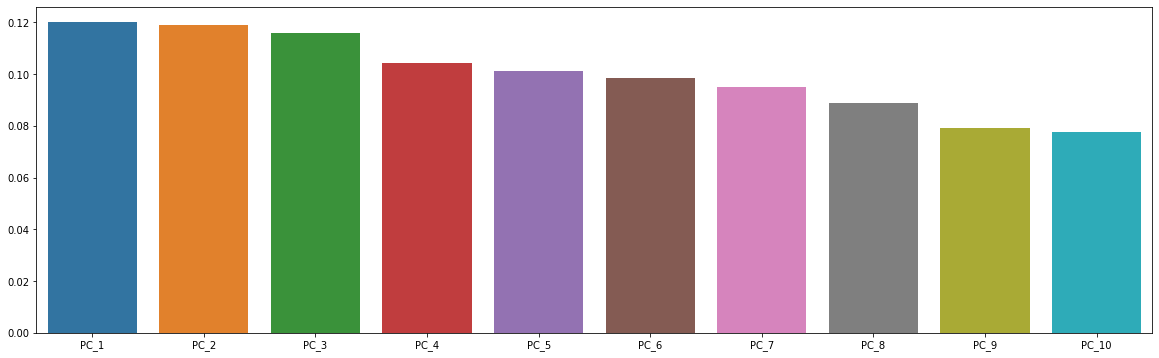

In [156]:
scaler_standard_for_pca = StandardScaler().fit(X_train)
X_train_standard = scaler_standard_for_pca.transform(X_train)

pca = PCA(random_state=42).fit(X_train_standard)
X_train_pca = pd.DataFrame(pca.transform(X_train_standard), index=X_train.index, columns=[f'PC_{i + 1}' for i in np.arange(X_train_standard.shape[1])])

plt.figure(figsize=(20, 6))
sns.barplot(x=X_train_pca.columns, y=pca.explained_variance_ratio_);

# Сохраняем Scaler (для дальнейшего использования в релизе модели)
pickle.dump(scaler_standard_for_pca, open('../../app/model_to_use/scaler_standard_for_pca_for_elasticity_model.pkl', 'wb'))

# Сохраняем PCA (для дальнейшего использования в релизе модели)
pickle.dump(pca, open('../../app/model_to_use/pca_for_elasticity_model.pkl', 'wb'))

# X_train to use

In [157]:
X_train_to_use = pd.concat([X_train_scaled, X_train_norm, X_train_cross_scaled, X_train_pca, cover_angle_train], axis=1).reset_index(drop=True)
X_train_to_use

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox,...,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,cover_angle
0,0.448777,0.124847,0.651683,0.744861,0.046176,0.278244,0.856872,0.036067,0.881006,0.094031,...,3.134799,-2.857369,0.208632,-1.939046,0.393807,1.335111,-2.685305,0.258732,-0.702735,0
1,0.453797,0.402979,0.594955,0.653875,0.660323,0.694003,0.337016,0.341362,0.568695,0.413007,...,-0.163128,-1.465232,-0.736393,0.080713,1.082486,-0.148069,0.731262,0.222391,-0.259117,0
2,0.677937,0.223343,0.721988,0.193497,0.502820,0.479975,0.430789,0.735419,0.890301,0.757944,...,-2.265617,-0.053402,0.889901,-0.387262,0.035972,-1.231001,-2.065352,0.262102,-1.516548,0
3,0.656368,0.638567,0.540990,0.366419,0.000000,0.960254,0.516119,0.720270,0.464316,0.392049,...,-0.035102,1.236739,-1.326619,0.243771,0.526499,0.444876,-1.314460,-2.920136,-0.058040,1
4,0.579068,0.390895,0.184787,0.726906,0.555591,0.246685,0.437235,0.712284,0.412874,0.351114,...,0.717202,0.432831,0.642885,0.677485,-0.463984,1.574969,0.904601,0.635751,-1.851024,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,0.492919,0.222074,0.656991,0.620361,0.434961,0.714668,0.559053,0.358506,0.420329,0.119437,...,0.206774,-1.801976,-0.941493,-0.803508,0.827870,1.593897,-0.298759,-0.817202,-0.005778,0
1287,0.421795,0.175919,0.498112,0.532515,0.428533,0.646205,0.391391,0.414704,0.498951,0.512098,...,-0.168188,-0.408862,-0.874032,-0.779746,1.054833,-0.057292,-0.351069,0.178304,-0.883227,1
1288,0.795275,0.053988,0.445037,0.401755,0.319892,0.518199,0.570995,0.471749,0.497074,0.586027,...,-0.692787,0.209998,-1.042118,-0.530144,-0.182480,0.798260,-2.141205,0.788973,-1.225413,1
1289,0.440618,0.327373,0.433996,0.496863,0.827585,0.268988,0.417527,0.321066,0.377752,0.594288,...,-0.289089,-0.480108,0.425195,0.080539,-0.189429,-0.237495,0.711991,2.021073,-0.000027,0


# Применяем все теже самые преобразования к X_test

In [158]:
# MinMax Re-scale (feature-wise)
X_test_scaled = pd.DataFrame(scaler_minmax.transform(X_test), index=X_test.index, columns=X_test.columns)

In [159]:
# Normalize (sample-wise)
X_test_norm = pd.DataFrame(scaler_normalize.transform(X_test), index=X_test.index, columns=[f'{col}_norm' for col in X_test.columns.tolist()])

In [160]:
# Multiply (cross-effects)

col_names = X_test.columns.tolist()
col_pair_combinations = list(itertools.combinations(col_names, 2))

X_test_cross = []

for col_pair in col_pair_combinations:
    X_test_cross.append(X_test.loc[:, col_pair].apply(lambda x: x[0] * x[1], axis=1))
    
X_test_cross = pd.DataFrame(X_test_cross).T
X_test_cross.columns = [f'{col_name[0]}_cross_{col_name[1]}' for col_name in col_pair_combinations]

X_test_cross_scaled = pd.DataFrame(scaler_minmax_for_cross.transform(X_test_cross), index=X_test_cross.index, columns=X_test_cross.columns.tolist())

In [161]:
# Apply PCA
X_test_standard = scaler_standard_for_pca.transform(X_test)
X_test_pca = pd.DataFrame(pca.transform(X_test_standard), index=X_test.index, columns=[f'PC_{i + 1}' for i in np.arange(X_test.shape[1])])

# X_test to use

In [162]:
X_test_to_use = pd.concat([X_test_scaled, X_test_norm, X_test_cross_scaled, X_test_pca, cover_angle_test], axis=1).reset_index(drop=True)
X_test_to_use

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox,...,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,cover_angle
0,0.610979,0.312055,0.507687,0.358149,0.189831,0.252080,0.306774,0.682588,0.037963,0.468622,...,-0.283684,1.899049,0.724637,0.735780,0.897996,1.567419,-1.199882,-0.079897,-0.123411,0
1,0.618553,0.655872,0.475334,0.341157,0.547173,0.712090,0.649727,0.884061,0.570064,0.472784,...,-1.167767,0.742897,0.173683,0.050220,-1.198826,0.144720,0.207088,-1.548902,-0.395357,1
2,0.588949,0.597303,0.865832,0.257636,0.791965,0.727592,0.273124,0.605660,0.278508,0.558658,...,-2.674900,-0.063511,0.101655,0.949006,0.800802,-0.373679,0.509845,-0.474320,1.450996,1
3,0.307961,0.647375,0.543225,0.603949,0.553838,0.413535,0.376732,0.439722,0.318338,0.328919,...,0.870594,-0.262543,0.734824,0.498264,0.736108,0.342702,1.202656,-0.220283,0.680394,0
4,0.622707,0.406213,0.367345,0.557320,0.323817,0.623900,0.377494,0.270699,0.204918,0.330419,...,0.844285,0.022159,-1.573452,0.791600,0.611531,1.056530,-0.309822,-0.128878,0.226824,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,0.292417,0.882299,0.700796,0.783222,0.740318,0.789582,0.483840,0.336936,0.349756,0.531833,...,0.444892,-0.501217,-0.540376,0.060847,1.122005,-0.344568,2.406067,-0.039309,1.886685,1
550,0.772153,0.146358,0.821852,0.729553,0.872151,0.892972,0.492866,0.239740,0.209033,0.492037,...,-2.036619,-1.775692,-2.353062,-0.410132,1.217832,1.627526,0.484434,1.510980,0.916709,0
551,0.818535,0.332347,0.199861,0.702621,0.315759,0.186653,0.439563,0.368679,0.578955,0.432431,...,1.612744,-0.042974,-0.184566,1.181693,-0.350179,1.176545,-1.164433,1.498209,-1.779496,1
552,0.795275,0.053988,0.445037,0.401755,0.319892,0.518199,0.570995,0.471749,0.497074,0.586027,...,-0.692787,0.209998,-1.042118,-0.530144,-0.182480,0.798260,-2.141205,0.788973,-1.225413,1


In [163]:
# scaler_minmax_to_use = pickle.load(open('../../app/model_to_use/scaler_minmax_for_elasticity_model.pkl', 'rb'))
# scaler_normalize_to_use = pickle.load(open('../../app/model_to_use/scaler_normalize_for_elasticity_model.pkl', 'rb'))
# scaler_minmax_for_cross_to_use = pickle.load(open('../../app/model_to_use/scaler_minmax_for_cross_for_elasticity_model.pkl', 'rb'))
# scaler_standard_for_pca_to_use = pickle.load(open('../../app/model_to_use/scaler_standard_for_pca_for_elasticity_model.pkl', 'rb'))
# pca_to_use = pickle.load(open('../../app/model_to_use/pca_for_elasticity_model.pkl', 'rb'))


# X_test_to_use = my_data_transformer(X_test, scaler_minmax_to_use, scaler_normalize_to_use, scaler_minmax_for_cross_to_use, scaler_standard_for_pca_to_use, pca_to_use)
# X_test_to_use

In [164]:
X_train_to_use.shape, X_test_to_use.shape

((1291, 76), (554, 76))

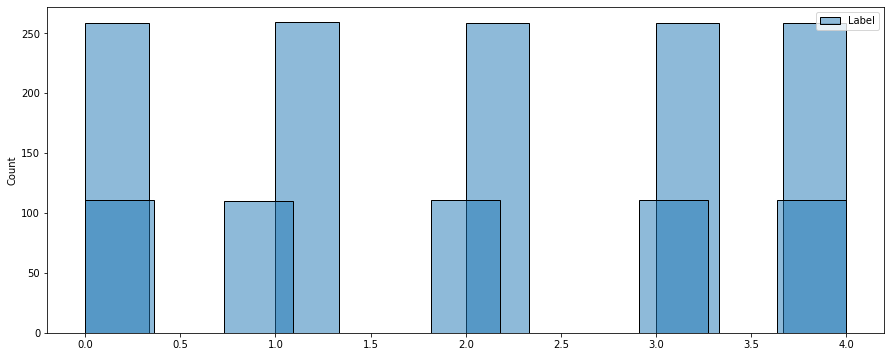

In [165]:
plt.figure(figsize=(15, 6))
sns.histplot(y_train)
sns.histplot(y_test);

# Fit and compare models

In [166]:
cv_to_use = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)

score_to_use = make_scorer(f1_score, average='weighted') # или score_to_use = make_scorer(accuracy_score)

In [167]:
# cv_to_use = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)
# score_to_use = make_scorer(f1_score, average='weighted') # или score_to_use = make_scorer(accuracy_score)



# clf_xgb = XGBClassifier(objective='multi:softmax',
#                         n_jobs=-1,
#                         random_state=42)

# params_xgb = {'n_estimators': [1000, 1500],
#               'max_depth': [5, 7],
#               'learning_rate': [0.001, 0.01, 0.1]}



# gsearch_xgb = GridSearchCV(estimator=clf_xgb, param_grid=params_xgb, scoring=score_to_use, cv=cv_to_use)
# gsearch_xgb.fit(X_train_to_use, y_train.values.ravel())

# print(gsearch_xgb.best_score_)
# print(gsearch_xgb.best_params_)


# clf_xgb_to_use = gsearch_xgb.best_estimator_

### Model_1

In [168]:
clf_xgb = XGBClassifier(objective='multi:softmax',
                        n_estimators = 1500,
                        max_depth=5,
                        learning_rate=0.01,
                        n_jobs=-1,
                        random_state=42).fit(X_train_to_use, y_train.values.ravel())

In [169]:
y_train_pred = clf_xgb.predict(X_train_to_use)
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       258
           1       1.00      1.00      1.00       259
           2       1.00      1.00      1.00       258
           3       1.00      1.00      1.00       258
           4       1.00      1.00      1.00       258

    accuracy                           1.00      1291
   macro avg       1.00      1.00      1.00      1291
weighted avg       1.00      1.00      1.00      1291



In [170]:
y_test_pred = clf_xgb.predict(X_test_to_use)
print(classification_report(y_test_pred, y_test.values.ravel()))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       112
           1       0.65      0.65      0.65       109
           2       0.44      0.48      0.46       103
           3       0.68      0.66      0.67       115
           4       1.00      0.97      0.98       115

    accuracy                           0.75       554
   macro avg       0.75      0.75      0.75       554
weighted avg       0.76      0.75      0.76       554



### Model_2

In [171]:
from sklearn.naive_bayes import GaussianNB
clf_gauss = GaussianNB().fit(X_train_to_use, y_train.values.ravel())

y_train_pred = clf_gauss.predict(X_train_to_use)
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       0.47      0.40      0.43       305
           1       0.22      0.31      0.26       185
           2       0.24      0.34      0.28       181
           3       0.31      0.33      0.32       249
           4       0.48      0.34      0.40       371

    accuracy                           0.35      1291
   macro avg       0.35      0.34      0.34      1291
weighted avg       0.38      0.35      0.35      1291



In [172]:
y_test_pred = clf_gauss.predict(X_test_to_use)
print(classification_report(y_test_pred, y_test.values.ravel()))

              precision    recall  f1-score   support

           0       0.35      0.34      0.34       116
           1       0.18      0.24      0.21        82
           2       0.12      0.16      0.14        79
           3       0.32      0.32      0.32       110
           4       0.50      0.34      0.40       167

    accuracy                           0.29       554
   macro avg       0.29      0.28      0.28       554
weighted avg       0.33      0.29      0.31       554



### Model 3

In [173]:
from sklearn.ensemble import AdaBoostClassifier
clf_adab = AdaBoostClassifier(n_estimators=1000, 
                              random_state=42).fit(X_train_to_use, 
                                                   y_train.values.ravel())

y_train_pred = clf_adab.predict(X_train_to_use)
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       0.61      0.86      0.71       184
           1       0.55      0.54      0.55       261
           2       0.53      0.41      0.46       336
           3       0.55      0.46      0.50       308
           4       0.68      0.87      0.77       202

    accuracy                           0.59      1291
   macro avg       0.59      0.63      0.60      1291
weighted avg       0.58      0.59      0.57      1291



In [174]:
y_test_pred = clf_adab.predict(X_test_to_use)
print(classification_report(y_test_pred, y_test.values.ravel()))

              precision    recall  f1-score   support

           0       0.56      0.76      0.64        82
           1       0.37      0.38      0.38       108
           2       0.40      0.31      0.35       142
           3       0.50      0.39      0.43       142
           4       0.56      0.78      0.65        80

    accuracy                           0.48       554
   macro avg       0.48      0.52      0.49       554
weighted avg       0.46      0.48      0.46       554



### Model 4

In [175]:
from sklearn.neighbors import KNeighborsClassifier
clf_neigh = KNeighborsClassifier(n_neighbors=3, 
                                 n_jobs=-1).fit(X_train_to_use, 
                                                y_train.values.ravel())

y_train_pred = clf_neigh.predict(X_train_to_use)
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       1.00      0.83      0.90       310
           1       0.70      0.69      0.69       262
           2       0.43      0.72      0.54       153
           3       0.78      0.74      0.76       272
           4       1.00      0.88      0.93       294

    accuracy                           0.78      1291
   macro avg       0.78      0.77      0.77      1291
weighted avg       0.82      0.78      0.79      1291



C:\Users\vkozy\AppData\Roaming\Python\Python310\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [176]:
y_test_pred = clf_neigh.predict(X_test_to_use)
print(classification_report(y_test_pred, y_test.values.ravel()))

              precision    recall  f1-score   support

           0       0.95      0.66      0.77       160
           1       0.43      0.41      0.42       115
           2       0.16      0.33      0.22        55
           3       0.30      0.38      0.33        88
           4       1.00      0.82      0.90       136

    accuracy                           0.57       554
   macro avg       0.57      0.52      0.53       554
weighted avg       0.67      0.57      0.61       554



C:\Users\vkozy\AppData\Roaming\Python\Python310\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


# Model 5

In [177]:
from sklearn.svm import SVC, LinearSVC
clf_svc = SVC(gamma=1, C=1).fit(X_train_to_use, y_train.values.ravel())

y_train_pred = clf_svc.predict(X_train_to_use)
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       258
           1       1.00      1.00      1.00       259
           2       1.00      1.00      1.00       258
           3       1.00      1.00      1.00       258
           4       1.00      1.00      1.00       258

    accuracy                           1.00      1291
   macro avg       1.00      1.00      1.00      1291
weighted avg       1.00      1.00      1.00      1291



In [178]:
y_test_pred = clf_svc.predict(X_test_to_use)
print(classification_report(y_test_pred, y_test.values.ravel()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       111
           1       0.53      1.00      0.69        58
           2       1.00      0.53      0.69       209
           3       0.59      1.00      0.74        65
           4       1.00      1.00      1.00       111

    accuracy                           0.82       554
   macro avg       0.82      0.91      0.82       554
weighted avg       0.90      0.82      0.82       554



### Model 6

In [179]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(activation='tanh', solver='adam', 
                        random_state=42, max_iter=1000)
clf_mlp.fit(X_train_to_use, y_train.values.ravel())

y_train_pred = clf_mlp.predict(X_train_to_use)
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       258
           1       1.00      1.00      1.00       259
           2       1.00      1.00      1.00       258
           3       1.00      1.00      1.00       258
           4       1.00      1.00      1.00       258

    accuracy                           1.00      1291
   macro avg       1.00      1.00      1.00      1291
weighted avg       1.00      1.00      1.00      1291



C:\Users\vkozy\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [180]:
y_test_pred = clf_mlp.predict(X_test_to_use)
print(classification_report(y_test_pred, y_test.values.ravel()))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       123
           1       0.64      0.72      0.68        97
           2       0.34      0.50      0.41        76
           3       0.71      0.61      0.66       130
           4       1.00      0.87      0.93       128

    accuracy                           0.74       554
   macro avg       0.74      0.72      0.72       554
weighted avg       0.78      0.74      0.75       554



### Model 7

In [181]:
clf_gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, random_state=42)
clf_gbc.fit(X_train_to_use, y_train.values.ravel())

GradientBoostingClassifier(n_estimators=1000, random_state=42)

In [182]:
y_train_pred = clf_gbc.predict(X_train_to_use)
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       258
           1       1.00      1.00      1.00       259
           2       1.00      1.00      1.00       258
           3       1.00      1.00      1.00       258
           4       1.00      1.00      1.00       258

    accuracy                           1.00      1291
   macro avg       1.00      1.00      1.00      1291
weighted avg       1.00      1.00      1.00      1291



In [183]:
y_test_pred = clf_gbc.predict(X_test_to_use)
print(classification_report(y_test_pred, y_test.values.ravel()))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       116
           1       0.72      0.65      0.68       122
           2       0.40      0.50      0.44        88
           3       0.68      0.65      0.67       117
           4       1.00      1.00      1.00       111

    accuracy                           0.76       554
   macro avg       0.76      0.75      0.75       554
weighted avg       0.78      0.76      0.77       554



### Model 8

In [184]:
clf_logist = LogisticRegression(multi_class='multinomial', fit_intercept=True, max_iter=500, n_jobs=-1)

params_logist = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                 'penalty': ['l1', 'l2']}

gsearch_logist = GridSearchCV(estimator=clf_logist, param_grid=params_logist, scoring=score_to_use, cv=cv_to_use)
gsearch_logist.fit(X_train_to_use, y_train.values.ravel())

print(gsearch_logist.best_score_)
print(gsearch_logist.best_params_)

C:\Users\vkozy\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\vkozy\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\vkozy\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\vkozy\AppData\Roaming\Python\Python310\site-packages\sklearn\li

0.34785332962755733
{'C': 1000, 'penalty': 'l2'}


In [185]:
clf_logist_to_use = gsearch_logist.best_estimator_

In [186]:
y_train_pred = clf_logist_to_use.predict(X_train_to_use)
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       0.62      0.56      0.59       287
           1       0.36      0.34      0.35       270
           2       0.30      0.37      0.33       210
           3       0.36      0.41      0.38       223
           4       0.60      0.51      0.55       301

    accuracy                           0.45      1291
   macro avg       0.45      0.44      0.44      1291
weighted avg       0.46      0.45      0.45      1291



In [187]:
y_test_pred = clf_logist_to_use.predict(X_test_to_use)
print(classification_report(y_test_pred, y_test.values.ravel()))

              precision    recall  f1-score   support

           0       0.50      0.52      0.51       105
           1       0.31      0.29      0.30       119
           2       0.14      0.16      0.15        93
           3       0.23      0.26      0.24        95
           4       0.57      0.44      0.50       142

    accuracy                           0.35       554
   macro avg       0.35      0.34      0.34       554
weighted avg       0.37      0.35      0.35       554



### Сохраняем модель самого лучшего качества

In [188]:
pickle.dump(clf_svc, open('../../app/model_to_use/elasticity_stretch_model.pkl', 'wb'))

In [189]:
# cv_to_use = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)

# # score_to_use = make_scorer(accuracy_score) 
# make_scorer(f1_score, average='weighted')


# clf_svc = SVC(random_state=42)

# params_svc = {'C': [1.4, 1.5, 1.6],
#               'gamma': [0.8, 0.9, 1.0],
#               'kernel': ['poly', 'rbf', 'sigmoid'],
#               'degree': [3, 4, 5, 6, 7]}

# gsearch_svc = GridSearchCV(estimator=clf_svc, param_grid=params_svc, scoring=score_to_use, cv=cv_to_use)
# gsearch_svc.fit(X_train_to_use, y_train.values.ravel())

# # print(gsearch_svc.best_score_)
# print(gsearch_svc.best_params_)

In [190]:
# svc_best_model_to_use = gsearch_svc.best_estimator_

In [191]:
# y_train_pred = svc_best_model_to_use.predict(X_train_to_use)
# print(classification_report(y_train_pred, y_train))

In [192]:
# y_test_pred = svc_best_model_to_use.predict(X_test_to_use)
# print(classification_report(y_test_pred, y_test.values.ravel()))